# K Hops (focused on homophily)

In [1]:
# these warnings are fine. you can ignore them.
import random, math

import sys
sys.path.append('../')
from util import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Imports finished.")

/home/wcorcoran/anaconda3/envs/mesp/lib/python3.8/site-packages/torch_geometric/typing.py:47: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/wcorcoran/anaconda3/envs/mesp/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/wcorcoran/anaconda3/envs/mesp/lib/python3.8/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/wcorcoran/anaconda3/envs/mesp/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Imports finished.


## Setting Up Dataset/Model/Ground Truth

In [2]:
dataset = Dataset(root='/tmp/Cora', name='Cora', device=device)
data, in_feats, h_feats, num_classes = dataset.get_data()

model = get_model(in_feats, h_feats, num_classes, "cora")
ground_truth = get_ground_truth(model, data, testMask=False)
print(ground_truth)

0.7581240768094535


## Experiments

**Note:** The ground truth here is $0.749$

In [3]:
homophilic_set = {label: [] for label in set(data.y.tolist())}

# test_indices = torch.nonzero(data.test_mask, as_tuple=False).squeeze()
G, x, y, train_mask, test_mask = convert_to_networkx(dataset.get_data()[0])
for i in G.nodes():
    homophilic_set[data.y[i].item()].append(i)

# print("This is the dictionary containing each class and its respective vertices:\n\t", homophilic_set)

In [4]:
for z in range(2, 5):
    print(z)
    data = dataset.get_data()[0]
    modified_graph = data
    
    init_edges = len(modified_graph.edge_index[1])
    
    G, x, y, train_mask, test_mask = convert_to_networkx(modified_graph)
    
    new_G = G.copy()
    
    for n in G.nodes():
        sub_nodes = nx.ego_graph(G, n, z).nodes()
    
        for i in sub_nodes:
            if y[n].item() == y[i].item() and i != n:
                add_edge(new_G, n, i, undirected=True)
    
    G = new_G.copy()
    
    modified_graph = convert_to_pyg(G, x, y, train_mask, test_mask)
    final_edges = len(modified_graph.edge_index[1])
    
    output_accuracy_change(ground_truth, test_model(model, modified_graph, testMask=False)) 
    number_added_edges(init_edges, final_edges, is_undirected=True)
    print("Number of k-hops considered:", z)

2

----
The accuracy has changed by 0.0956
Change in edges:  31260.0  | Percentage change: 592.27%
Number of k-hops considered: 2
3

----
The accuracy has changed by 0.1677
Change in edges:  92929.0  | Percentage change: 1760.69%
Number of k-hops considered: 3
4

----
The accuracy has changed by 0.2013
Change in edges:  186538.0  | Percentage change: 3534.26%
Number of k-hops considered: 4


In [5]:
G, x, y, train_mask, test_mask = convert_to_networkx(modified_graph)

edge_homo = [0] * len(G.nodes())

for n in G.nodes():
    edge_homo[n] = get_node_homophily(G, n, y, y[n].item())

for c in range(1, 11):
    c = 0.1 * c
    z = 2
    data = dataset.get_data()[0]
    modified_graph = data
    
    init_edges = len(modified_graph.edge_index[1])
    
    G, x, y, train_mask, test_mask = convert_to_networkx(modified_graph)
    
    new_G = G.copy()
    
    for n in G.nodes():
        sub_nodes = nx.ego_graph(G, n, z).nodes()
    
        for i in sub_nodes:
            if y[n].item() == y[i].item() and i != n and edge_homo[i] >= c:
                add_edge(new_G, n, i, undirected=True)
    
    G = new_G.copy()
    
    modified_graph = convert_to_pyg(G, x, y, train_mask, test_mask)
    final_edges = len(modified_graph.edge_index[1])
    
    output_accuracy_change(ground_truth, test_model(model, modified_graph, testMask=False)) 
    number_added_edges(init_edges, final_edges, is_undirected=True)
    print("Number of k-hops considered:", z, " | Density considered: ", c)


----
The accuracy has changed by 0.0960
Change in edges:  31205.0  | Percentage change: 591.23%
Number of k-hops considered: 2  | Density considered:  0.1

----
The accuracy has changed by 0.0956
Change in edges:  31193.0  | Percentage change: 591.00%
Number of k-hops considered: 2  | Density considered:  0.2

----
The accuracy has changed by 0.0960
Change in edges:  31131.0  | Percentage change: 589.83%
Number of k-hops considered: 2  | Density considered:  0.30000000000000004

----
The accuracy has changed by 0.0956
Change in edges:  30989.0  | Percentage change: 587.14%
Number of k-hops considered: 2  | Density considered:  0.4

----
The accuracy has changed by 0.0949
Change in edges:  30908.0  | Percentage change: 585.60%
Number of k-hops considered: 2  | Density considered:  0.5

----
The accuracy has changed by 0.0890
Change in edges:  30233.0  | Percentage change: 572.81%
Number of k-hops considered: 2  | Density considered:  0.6000000000000001

----
The accuracy has changed by

In [6]:
print(edge_homo)

[1.0, 1.0, 0.4, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 1.0, 1.0, 0.5, 0.0, 0.5, 0.8888888888888888, 1.0, 1.0, 1.0, 0.3333333333333333, 0.5, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.8888888888888888, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 0.25, 1.0, 0.0, 1.0, 1.0, 0.3333333333333333, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.42857142857142855, 1.0, 0.6666666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.75, 0.6666666666666666, 0.2777777777777778, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2727272727272727, 0.9523809523809523, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.625, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.84375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2631578947368421, 1.0, 0.8, 0.7142857142857143, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [7]:
G, x, y, train_mask, test_mask = convert_to_networkx(modified_graph)

edge_homo = [0] * len(G.nodes())

for n in G.nodes():
    edge_homo[n] = get_node_homophily(G, n, y, y[n].item())

for c in range(1, 11):
    c = 0.1 * c
    z = 2
    data = dataset.get_data()[0]
    modified_graph = data
    
    init_edges = len(modified_graph.edge_index[1])
    
    G, x, y, train_mask, test_mask = convert_to_networkx(modified_graph)
    
    new_G = G.copy()
    
    for n in G.nodes():
        sub_nodes = nx.ego_graph(G, n, z).nodes()
    
        for i in sub_nodes:
            if y[n].item() == y[i].item() and i != n and edge_homo[i] >= c and len(G.out_edges(i)) >= 10:
                add_edge(new_G, n, i, undirected=True)
    
    G = new_G.copy()
    
    modified_graph = convert_to_pyg(G, x, y, train_mask, test_mask)
    final_edges = len(modified_graph.edge_index[1])
    
    output_accuracy_change(ground_truth, test_model(model, modified_graph, testMask=False)) 
    number_added_edges(init_edges, final_edges, is_undirected=True)
    print("Number of k-hops considered:", z, " | Density considered: ", c)


----
The accuracy has changed by 0.0476
Change in edges:  5597.0  | Percentage change: 106.04%
Number of k-hops considered: 2  | Density considered:  0.1

----
The accuracy has changed by 0.0476
Change in edges:  5597.0  | Percentage change: 106.04%
Number of k-hops considered: 2  | Density considered:  0.2

----
The accuracy has changed by 0.0480
Change in edges:  5583.0  | Percentage change: 105.78%
Number of k-hops considered: 2  | Density considered:  0.30000000000000004

----
The accuracy has changed by 0.0473
Change in edges:  5538.0  | Percentage change: 104.93%
Number of k-hops considered: 2  | Density considered:  0.4

----
The accuracy has changed by 0.0451
Change in edges:  5463.0  | Percentage change: 103.51%
Number of k-hops considered: 2  | Density considered:  0.5

----
The accuracy has changed by 0.0451
Change in edges:  5415.0  | Percentage change: 102.60%
Number of k-hops considered: 2  | Density considered:  0.6000000000000001

----
The accuracy has changed by 0.041

In [6]:
G, x, y, train_mask, test_mask = convert_to_networkx(dataset.get_data()[0])

edge_homo = [0] * len(G.nodes())

for n in G.nodes():
    edge_homo[n] = get_node_homophily(G, n, y, y[n].item())

# for c in range(2, 3):
for c in range(1, 11):
    sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
    top_nodes = [node for node, degree in sorted_nodes[:int(len(G) * c * 0.01)]]
    print(len(top_nodes))
# 
    # def degree_nth_percentile(graph, percentile):
    # # Get degrees of all nodes in the graph
    #     degrees = [degree for node, degree in graph.degree()]
    
    #     # Calculate the nth percentile degree
    #     nth_percentile_degree = np.percentile(degrees, percentile)
    
    #     return nth_percentile_degree
        
    # # Calculate the degree in the 75th percentile
    # nth_percentile_degree = degree_nth_percentile(G, c)
    # print("Degree in the cth percentile:", nth_percentile_degree)

    z = 2
    data = dataset.get_data()[0]
    modified_graph = data
    
    init_edges = len(modified_graph.edge_index[1])
    
    G, x, y, train_mask, test_mask = convert_to_networkx(modified_graph)
    
    new_G = G.copy()

    unique_adds = set()
    
    for n in G.nodes():
        sub_nodes = nx.ego_graph(G, n, z).nodes()
    
        for i in sub_nodes:
            if y[n].item() == y[i].item() and i != n and edge_homo[i] == 1 and i in top_nodes:
                # print(i)
                unique_adds.add(i)
                # print("Adding edge: ", n, " - ", i, " | Degree of i: ", len(G.out_edges(i)))
                add_edge(new_G, n, i, undirected=True)
    
    G = new_G.copy()

    # print_graph(G)

    print("Unique Adds:", len(unique_adds))
    
    modified_graph = convert_to_pyg(G, x, y, train_mask, test_mask)
    final_edges = len(modified_graph.edge_index[1])
    
    output_accuracy_change(ground_truth, test_model(model, modified_graph, testMask=False)) 
    number_added_edges(init_edges, final_edges, is_undirected=True)
    print("Number of k-hops considered:", z, " | Degree size considered: ", c * 0.01)

27
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


KeyboardInterrupt: 

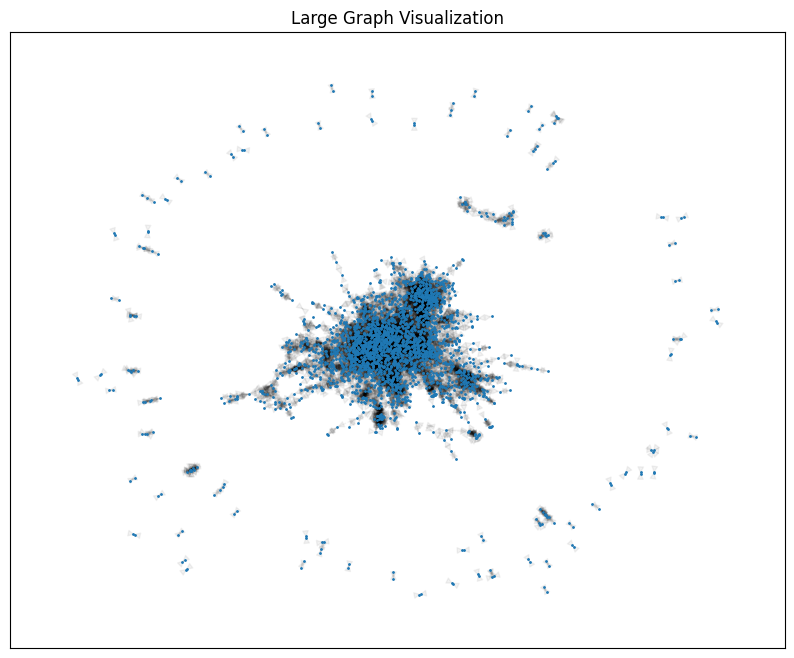

In [3]:
G, x, y, train_mask, test_mask = convert_to_networkx(dataset.get_data()[0])
print_graph(G)